<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [51]:
!echo "$AUTH {AUTH}"

\/content/drive/MyDrive/m/auth /content/drive/MyDrive/m/auth


In [55]:
repo='https://github.com/avinashmane/colab.git'
import os,sys
if os.name=='nt':
    LIB= r'c:\m\lib'
    LOG= r'c:\m\social-media-automation'
    AUTH= r'c:\i\auth'
else:
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    LIB='/content/drive/MyDrive/m/lib'
    LOG='/content/drive/MyDrive/m/lib'
    AUTH='/content/drive/MyDrive/m/auth'
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    if not os.path.exists('repo'):
      !git clone $repo repo
sys.path.append(LIB)
sys.path.append('repo')

Cloning into 'repo'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 12), reused 15 (delta 5), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [2]:
if os.name!='nt':
    !pip install nerodia
    !pip install pygsheets
    if True:
      !apt-get update # to update ubuntu to correctly run apt install
      if False:
        !apt install firefox-geckodriver
        !cp /usr/bin/geckodriver {DIR}
        !cp -r /usr/lib/firefox/ {DIR}
      if True:
        !apt install chromium-chromedriver
        !cp /usr/lib/chromium-browser/chromedriver {DIR}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 31.4 MB/s 
     |████████████████████████████████| 985 kB 41.9 MB/s 
     |████████████████████████████████| 139 kB 45.6 MB/s 
     |████████████████████████████████| 358 kB 57.5 MB/s 
     |████████████████████████████████| 4.1 MB 41.0 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.11 which is incompatible.
Looking in indexes: https://pypi.org/simple, ht

In [3]:
import yaml
cfg=yaml.load("""
sheets:
    stravasync:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: Members
        range: A10:O
    StravaPromoLog:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: StravaPromoLog
        
""",Loader=yaml.Loader)

## Code

In [4]:
import yaml
import time
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

def setLogger(logFile=None,level=logging.INFO):
    # level = logging.INFO if level is None else 
    from imp import reload
    # jupyter notebook already uses logging, thus we reload the module to make it work in notebooks
    # http://stackoverflow.com/questions/18786912/get-output-from-the-logging-module-in-ipython-notebook
    reload(logging)
    logging.basicConfig( level=level,
                    format='%(asctime)s:%(levelname)s:%(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
                    
    if logFile:
        logger = logging.getLogger()
        fhandler = logging.FileHandler(filename=logFile, mode='a',encoding='utf-8')
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'
                                     ,datefmt='%Y-%m-%d %H:%M:%S')
        fhandler.setFormatter(formatter)
        logger.addHandler(fhandler)
        logger.setLevel(level)
        
    logging.info("Logger file: "+logFile if logFile else "None")


class SocialMediaSite:
    "Generic website"
    authType=None
    cfg={}

    giveKudosPattern=re.compile(r'.*ive kudos')    
    def __init__(self,b,browser='firefox',authFile=f'{AUTH}/auth.yaml'):
        # create brwoser unless provided
        self.browser=Browser(browser) if b==None else b
        nerodia.default_timeout=10
        with open(authFile) as file:
            # The FullLoader parameter handles the conversion from YAML
            # scalar values to Python the dictionary format
            auth = yaml.safe_load(file)
            self.auth={x:auth[x] for x in auth if x in ['strava','facebook']}
        
    def login():
      raise NotImplemented
      
    def loadCookie(self,cookieFile):
        if cookieFile and os.path.exists(cookieFile):
          self.browser.cookies.load(file=cookieFile)
          
    def saveCookie(self,cookieFile):
        return self.browser.cookies.save(file=cookieFile)
    def clearCookie(self,cookieFile):
        return self.browser.cookies.clear()
    def close(self):
        return self.browser.close()
    @staticmethod
    def getParent(el,tag,patClass):
      """
      Get parents with tag and patterm of class matching
      Parameters
      ----------
      - el : reference node
      - tag : tag_type (e.g. div)
      - patClass : class of patterns (re.compile)
      Returns
      -------
      - Single element than meets the requirements
      """
      return el._xpath_adjacent( tag_name='div',class_name=re.compile(patClass), adjacent='ancestor', plural=False)
    
    @staticmethod
    def getLinkByClassPatt(tag,classPattern): 
        x= tag.link(class_name=re.compile(classPattern))
        return x.href,x.text
    
    @staticmethod
    def _dumptag(el,tags=None,level=0):
      for c in el.children(tag_name=tags):
          print(' '*level,c.tag_name,c.id,c.text[:50])
          SocialMediaSite._dumptag(c,level+1)
    
        

In [30]:
class Strava(SocialMediaSite):
    authType='strava'
    def __init__(self,b=None,cookieFile=None,authFile=f'{AUTH}/auth.yaml',cfgFile=f'{LIB}/cfg_strava.yaml'):
        super().__init__(b,authFile=authFile)
        self.siteType='strava'
        
        with open(cfgFile) as file:
            cfg = yaml.safe_load(file)
            self.cfg.update(cfg['strava'])

    def login(self,login):
        auth=self.auth[self.authType][login]
        self.browser.goto('https://www.strava.com/login')

        try: # reject cookies
          rejButton=self.browser.button(value="Reject")
          if rejButton.exists:
            rejButton.click()
        except Exception as e:
            logging.warning( f"Error login1 {e!r}") #logging.warning 
      
        try:
          self.browser.text_field(id='email').value=auth['username']  #timeout did not work
          self.browser.text_field(id='password').value=auth['password']
          self.browser.button(id='login-button').click()
        except Exception as e:
          if 'dashboard' in self.browser.url:
            pass
          else:
            logging.warning( f"Error Login2 {e!r}") #logging.warning 
        
    def getClubs(self):
        self.browser.goto('https://www.strava.com/clubs/search')
        grps=[]
        # print(self.browser.ul(class_name="clubs").lis())
        for f in self.browser.ul(class_name="clubs").lis():
          # print(f.div().attribute_value("original-title"))
          for c in f.div().links():
            grps.append({"name":f.div().attribute_value("original-title"),
                         "link":c.attributes['href']})
        return (grps)
      
    def postInClub(self,club,title,text,imagePath):
        self.browser.goto(f'{club}/discussion')
        self.browser.link(id='new-post').click()
        self.browser.textarea(name='title').value=title
        self.browser.textarea(name='text').value=text
        # self.b.file_field(type='file').set='c:\\temp\\9955-2Certificate.png' #not working
        self.browser.file_field(type='file',index=0).value=imagePath #working
        self.browser.div(class_name="dropzone-previews").img().wait_until(method=lambda e: e.complete)
        time.sleep(3)
        self.browser.button(text='Publish').click()
        
    def getPostIds(self,club):
        self.browser.goto(f'{club}/discussion')
        return [{'id':x.parent().id,
          'title':   x.div(class_name='post-body').link().text,
          'link':    x.link(class_name='str-click-self-js').href,
          'userlink':x.link(class_name='str-click-name-js').href,
          'username':x.link(class_name='str-click-name-js').text,
          'time':    x.time().text,
          'kudos':   x.span(class_name="count-kudos").text,
          'comments':x.span(class_name="count-comments").text,
          } for x in self.browser.divs(class_name='topic')]
      
    def deletePost(self,id):
        "@id like post-19361836"
        self.browser.li(id=id).div(class_name='drop-down-menu').click()
        self.browser.li(id=id).button(text='Delete').click()
        self.browser.alert.ok()

    def deleteCurrentPost(self):
        "delete current post"
        self.browser.div(id="options-menu").click()
        self.browser.div(id="options-menu").link(text="Edit").click()

        self.browser.button(text='Delete').click()
        self.browser.alert.ok()
    def giveKudos(self):
      "Give Kudos in current screen"
      _=self.browser.buttons(title=self.giveKudosPattern)
      for i,x in enumerate(_):
        try:
          self.browser.execute_script("arguments[0].click();", x)
          card=strava.getParent(x,'div','^Card')
          athId,_=SocialMediaSite.getLinkByClassPatt(card,"^Avatar--")
          actId,_=SocialMediaSite.getLinkByClassPatt(card,"^ActivityEntryBody--")
          hdr= card.div(class_name=re.compile("^MediaBody--media-body--"))
          if hdr.exists:
            name=hdr.link().text
            loc=hdr.div(class_name=re.compile('^LocationAndTime--location--')).text
            try:
              id = int(re.findall(".*\/([0-9]*)",athId)[0])
              if id not in StravaMembers:
                id='nonMember'
            except:
              id='not valid'          
        except Exception as e: 
          logging.warning(f"giveKudos: {i} error clicking {e!r}")
        else:
            ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","giveKudos",id,athId,name,actId,loc,]])    
            logging.info(f"giveKudos: {i},{id},{athId} {actId} {hdr.text.split(',')[:1]}")

        time.sleep(.5)
      return 
    def scrolldown(self,pages):
      for i in range(pages):
        b.driver.execute_script("window.scrollTo(0,document.body.scrollHeight)")
        # b.send_keys(Keys.CONTROL  + Keys.END )     
        # b.driver.execute_script("window.scrollBy(0, document.body.scrollHeight);")
        time.sleep(1)
    def goto(self,url):
      return self.browser.goto(url)
    def image(self):
      b.execute_script("window.scrollTo(0,0)")
      return Image(b.screenshot.png())

        

In [6]:
"reach gsheet"
import pygsheets
import json,re
import pandas as pd

class Gsheet:
    def __init__(self,url):
        self.client = pygsheets.authorize(service_account_file=f'{AUTH}/indiathon-04d51b0b4caa.json')        
        if re.match("^https+://",url):
            self.ws=self.client.open_by_url(url)
        else:
            self.sheet=cfg['sheets'][url]
            self.ws=self.client.open_by_url(self.sheet['url'])
    def getSheetByTitle(self,sheet):
        return self.ws.worksheet_by_title(sheet)
    def getSheetDf(self,sheet=None,start=None):
        if (sheet==None) and self.sheet: sheet=self.sheet['tab']
        if (start==None) and self.sheet: start=self.sheet['range'].split(':')[0]
        return self.getSheetByTitle(sheet).get_as_df(start=start)

In [7]:
"test"
if True: # "Testing for getting information":
    pass
if False:    
    giveKudosPattern=re.compile(r'.*ive kudos')    
    bbuttons=b.buttons(title=giveKudosPattern)
    x1=strava.getParent(bbuttons[0],'div','^Card')
    for button in bbuttons:
        card=strava.getParent(button,'div','^Card')
        athId,_=SocialMediaSite.getLinkByClassPatt(card,"^Avatar--")
        actId,_=SocialMediaSite.getLinkByClassPatt(card,"^ActivityEntryBody--")
        
        # display([(x.href,x.class_name) for x in x1.links(class_name=re.compile("^Avatar--"))] )
        display(athId,actId)


In [12]:
df_mc=Gsheet('stravasync').getSheetDf('Members')
StravaMembers=df_mc.query('strava=="strava"').id.values
# ssl=Gsheet('stravasync')
# df_mc

# Process
## Create headless

In [32]:
" Test Selenium headless"
if True:
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    # b.get("https://www.google.com")
    setLogger(f"{LOG}/strava-automation.log")
    ss = Gsheet('stravasync').getSheetByTitle('StravaPromoLog')

2022-08-11 05:56:40:INFO:Logger file: /content/drive/MyDrive/m/lib/strava-automation.log


In [33]:
# %debug
# if os.name=='nt':
strava=Strava(b,authFile=f'{AUTH}/auth.yaml',cfgFile=f"{LIB}/cfg_strava.yaml")
# else:
#   strava=Strava(b,authFile=r'/content/drive/MyDrive/m/auth/auth.yaml',cfgFile="/content/drive/MyDrive/m/social-media/cfg_strava.yaml")
# test case
# strava.login("avinash")

In [34]:
strava.login("avinash")

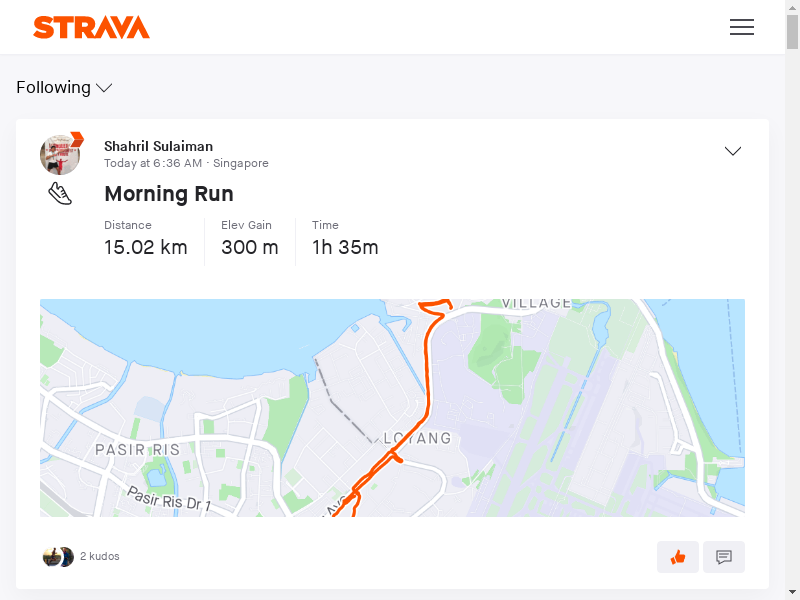

In [35]:
Image(b.screenshot.png())

## A. Give likes in feed

In [36]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')

strava.scrolldown(9)

In [37]:
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")

2022-08-11 05:57:00:INFO:Total number of cards on Dashboard | Strava: 79


In [38]:
strava.giveKudos()

2022-08-11 05:57:13:WARNING:giveKudos: 0 error clicking UnknownObjectException("timed out after 10 seconds, waiting for #<Div: located: False; {'title': re.compile('.*ive kudos'), 'tag_name': 'button', 'index': 0} --> {'tag_name': 'div', 'class_name': re.compile('^Card'), 'adjacent': 'ancestor'} --> {'class_name': re.compile('^MediaBody--media-body--'), 'tag_name': 'div'} --> {'class_name': re.compile('^LocationAndTime--location--'), 'tag_name': 'div'}> to be located")
2022-08-11 05:57:25:WARNING:giveKudos: 1 error clicking UnknownObjectException("timed out after 10 seconds, waiting for #<Div: located: False; {'title': re.compile('.*ive kudos'), 'tag_name': 'button', 'index': 1} --> {'tag_name': 'div', 'class_name': re.compile('^Card'), 'adjacent': 'ancestor'} --> {'class_name': re.compile('^MediaBody--media-body--'), 'tag_name': 'div'} --> {'class_name': re.compile('^LocationAndTime--location--'), 'tag_name': 'div'}> to be located")
2022-08-11 05:57:36:WARNING:giveKudos: 2 error click

## Give likes on Club

In [39]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')
strava.login("strava_pcmcrunners")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")


2022-08-11 06:01:22:INFO:Total number of cards on Dashboard | Strava: 19


In [40]:
for club in strava.cfg['pcmcrunners']['clubs']:
  strava.goto(f"{club}/recent_activity")
  logging.info(f"Total number of cards on {club} '{strava.browser.title}': {len(b.divs(class_name=re.compile('^Card')))}")

  logging.info(f"===> ")
  time.sleep(1)
  strava.giveKudos()

2022-08-11 06:01:28:INFO:Total number of cards on https://www.strava.com/clubs/pcmcrunners 'Pimpri-Chinchwad, Maharashtra, India Club | PCMCRunners on Strava': 20
2022-08-11 06:01:28:INFO:===> 
2022-08-11 06:01:31:INFO:giveKudos: 0,nonMember,https://www.strava.com/athletes/73964312 https://www.strava.com/activities/7618471145 ['HARIKUMAR B\nToday at 5:59 AM\n · Punalur']
2022-08-11 06:01:33:INFO:giveKudos: 1,nonMember,https://www.strava.com/athletes/35062106 https://www.strava.com/activities/7618397707 ['AJINKYA NIMBALKAR\nToday at 9:05 AM\n · Pune City']
2022-08-11 06:01:35:INFO:giveKudos: 2,38519306,https://www.strava.com/athletes/38519306 https://www.strava.com/activities/7618363657 ['Anoopkumar Choudhary\nToday at 9:50 AM\n · Haveli']
2022-08-11 06:01:37:INFO:giveKudos: 3,nonMember,https://www.strava.com/athletes/23280219 https://www.strava.com/activities/7618354816 ['Aditya Chauhan\nToday at 7:50 AM\n · Pune City']
2022-08-11 06:01:38:INFO:giveKudos: 4,nonMember,https://www.strava

# Test

In [41]:
## Comment on PCMC club
strava.goto("https://www.strava.com/clubs/196654/recent_activity")

'https://www.strava.com/clubs/196654/recent_activity'

In [42]:
card=strava.getParent(x1[0],'div','^Card')

NameError: ignored

In [ ]:
card.text
[x.link().text for x in [card.div(class_name=re.compile("^MediaBody--media-body--"))]]

In [ ]:
KudosButtons=strava.browser.buttons(title=strava.giveKudosPattern)
for i,x in enumerate(KudosButtons):
  try:
    card=strava.getParent(x,'div','^Card')
    athId,ath=SocialMediaSite.getLinkByClassPatt(card,"^Avatar--")
    actId,_=SocialMediaSite.getLinkByClassPatt(card,"^ActivityEntryBody--")
    for x in card.divs(class_name=re.compile("^MediaBody--media-body--")):
        name=x.link().text
        if x.exists:
            locEl=x.div(class_name=re.compile('^LocationAndTime--location--',)).wait_until(timeout=0.1, method=lambda _: True)
            loc=locEl
    # text=card.text.split(',')[:1]
    print(name,loc)
    # x.click() 
    try:
        x = int(re.findall(".*\/([0-9]*)",athId)[0])
        if x not in StravaMembers:
            x='nonMember'
    except:
        x='not valid'

    # self.browser.execute_script("arguments[0].click();", x)
    ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","Comments",x,athId,name,actId,loc,]])    
    logging.info(f"giveKudos: {i},{x} {athId} {actId} {name}")
  except Exception as e: 
    logging.warning(f"giveKudos: {i} error clicking {e!r}")


In [ ]:
b.link(href="#container-nav").click()

In [ ]:
b.button(title="Expand profile menu").hover()

In [ ]:
[(x.text,x.class_name,x.tag_name) for x in b.button(title="Expand profile menu").span().span()]

In [ ]:
# b.execute_script("window.scrollTo(0,0)")
# Image(b.screenshot.png())
re.findall(".*\/([0-9]*)","https://www.strava.com/athletes/27331750")[0]

In [ ]:
"get all attributes"
# for x in dir(b):
#   print(x,type(getattr(b,x)),)

# New section


Cloning into 'colab'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 12), reused 15 (delta 5), pack-reused 0
Unpacking objects: 100% (31/31), done.
